In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [3]:

Path.cwd()

PosixPath('/Users/sonya0706/Documents/CSI/payload-2025-26/model')

In [4]:
# Reading simulated data from sim
BASE_DIR = Path.cwd()          # model/
csv_path = BASE_DIR.parent / "sim" / "calisto_flight_data.csv"

df = pd.read_csv(csv_path)

In [5]:
df.head()

,# Time (s),acceleration Magnitude (m/s²),Vz (m/s),Z (m)
0,0.000000,71.195328,0.000000,906.565430
1,0.006110,71.204258,0.433378,906.568077
2,0.012219,71.213147,0.866811,906.573373
3,0.022219,71.227608,1.576304,906.585589
4,0.032219,71.241932,2.285941,906.604900


In [6]:
# Rename columns
df = df.rename(columns = {"# Time (s)":"time", " acceleration Magnitude (m/s²)":"acceleration", " Vz (m/s)":"vz", " Z (m)":"z"})

In [7]:
# set index time 
df = df.sort_values("time").reset_index(drop=True)
df

,time,acceleration,vz,z
0,0.000000,71.195328,0.000000,906.565430
1,0.006110,71.204258,0.433378,906.568077
2,0.012219,71.213147,0.866811,906.573373
3,0.022219,71.227608,1.576304,906.585589
4,0.032219,71.241932,2.285941,906.604900
...,...,...,...,...
35605,355.469250,0.020294,-5.388236,906.732272
35606,355.479250,0.020294,-5.388219,906.678390
35607,355.489250,0.020294,-5.388202,906.624508
35608,355.499250,0.020294,-5.388185,906.570626


In [8]:
# normalize features
features = ["acceleration", "vz", "z"]
X_raw = df[features].to_numpy()   # (T, 3)

mu = X_raw.mean(axis=0, keepdims=True)
sigma = X_raw.std(axis=0, keepdims=True) + 1e-8

X_norm = (X_raw - mu) / sigma

In [9]:
df[features] = X_norm

In [10]:
df[features].describe()

,acceleration,vz,z
count,3.561000e+04,3.561000e+04,3.561000e+04
mean,-2.873298e-17,1.117394e-17,2.298639e-16
std,1.000014e+00,1.000014e+00,1.000014e+00
min,-2.456313e-01,-3.997062e-01,-1.236714e+00
25%,-2.443032e-01,-3.692524e-01,-8.970844e-01
50%,-2.422952e-01,-3.414056e-01,-2.655875e-01
75%,-2.392441e-01,-1.101503e-01,8.736883e-01
max,7.704524e+00,6.382791e+00,1.917674e+00


In [11]:
assert not df[features].isna().any().any()
assert np.isfinite(df[features].to_numpy()).all()

Makeing Sliding Windows

In [12]:
def make_windows(X, window_len=52, stride=13):
    windows = []
    for start in range(0, len(X) - window_len + 1, stride):
        windows.append(X[start:start + window_len])
    return np.stack(windows)

X = X_norm      # (T, 3)
X_win = make_windows(X, 52, 13)  

In [13]:
print(X_win.shape)

(2736, 52, 3)


Testing Out Model 

In [14]:
# Read model from .py file
from cnn1d import CAE1D

2026-02-15 14:54:57.740584: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model = CAE1D(window_length=52)
ae = model.build_cnn1d_autoencoder()
ae.summary()

Model: "1DCAE_unsupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 52, 3)]           0         
                                                                 
 encoder_1dcae (Functional)  (None, 13, 32)            3344      
                                                                 
 decoder_1dcae (Functional)  (None, None, 3)           4803      
                                                                 
Total params: 8,147
Trainable params: 8,147
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Training model 
history = ae.fit(
    X_win,
    X_win,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.1
)

Epoch 1/50
77/77 [==============================] - 0s 3ms/step - loss: 0.1663 - val_loss: 0.4777
Epoch 2/50
77/77 [==============================] - 0s 2ms/step - loss: 0.1522 - val_loss: 0.4777
Epoch 3/50
77/77 [==============================] - 0s 2ms/step - loss: 0.1507 - val_loss: 0.4777
Epoch 4/50
77/77 [==============================] - 0s 2ms/step - loss: 0.1500 - val_loss: 0.4777
Epoch 5/50
77/77 [==============================] - 0s 2ms/step - loss: 0.1494 - val_loss: 0.4777
Epoch 6/50
77/77 [==============================] - 0s 2ms/step - loss: 0.1490 - val_loss: 0.4777
Epoch 7/50
77/77 [==============================] - 0s 2ms/step - loss: 0.1485 - val_loss: 0.4777
Epoch 8/50
77/77 [==============================] - 0s 2ms/step - loss: 0.1482 - val_loss: 0.4777
Epoch 9/50
77/77 [==============================] - 0s 2ms/step - loss: 0.1478 - val_loss: 0.4776
Epoch 10/50
77/77 [==============================] - 0s 2ms/step - loss: 0.1476 - val_loss: 0.4776
Epoch 11/50
77/77 [

In [49]:
# Reconstruction and anomaly score
X_hat = ae.predict(X_win)
recon_error = np.mean((X_win - X_hat)**2, axis=(1, 2))

86/86 [==============================] - 0s 695us/step


In [50]:
len(recon_error)

2736

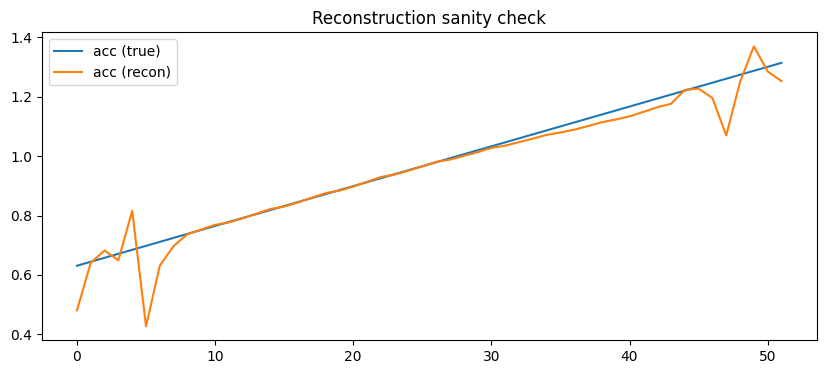

In [51]:
# window number 

i = 4

plt.figure(figsize=(10, 4))
plt.plot(X_win[i, :, 1], label="acc (true)")
plt.plot(X_hat[i, :, 1], label="acc (recon)")
plt.legend()
plt.title("Reconstruction sanity check")
plt.show()

In [52]:
threshold = np.percentile(recon_error, 95)

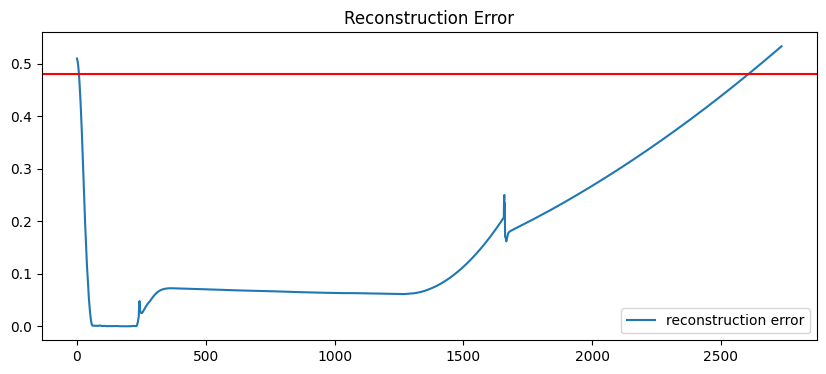

In [53]:


plt.figure(figsize=(10, 4))
plt.plot(recon_error, label="reconstruction error")
plt.axhline(threshold, color='r')
plt.legend()
plt.title("Reconstruction Error")
plt.show()

(array([183.,   6.,  19.,  16.,  21., 397., 701.,  41.,  32.,  28.,  26.,
         23.,  21.,  20.,  19.,  26.,  30.,  59.,  57.,  49.,  42.,  40.,
         39.,  39.,  37.,  36.,  35.,  35.,  34.,  34.,  33.,  32.,  32.,
         32.,  31.,  31.,  31.,  30.,  29.,  29.,  30.,  28.,  28.,  28.,
         29.,  28.,  29.,  30.,  25.,  26.]),
 array([3.72593455e-04, 1.10275393e-02, 2.16824852e-02, 3.23374311e-02,
        4.29923769e-02, 5.36473228e-02, 6.43022687e-02, 7.49572145e-02,
        8.56121604e-02, 9.62671063e-02, 1.06922052e-01, 1.17576998e-01,
        1.28231944e-01, 1.38886890e-01, 1.49541836e-01, 1.60196781e-01,
        1.70851727e-01, 1.81506673e-01, 1.92161619e-01, 2.02816565e-01,
        2.13471511e-01, 2.24126457e-01, 2.34781403e-01, 2.45436348e-01,
        2.56091294e-01, 2.66746240e-01, 2.77401186e-01, 2.88056132e-01,
        2.98711078e-01, 3.09366024e-01, 3.20020969e-01, 3.30675915e-01,
        3.41330861e-01, 3.51985807e-01, 3.62640753e-01, 3.73295699e-01,
        3.

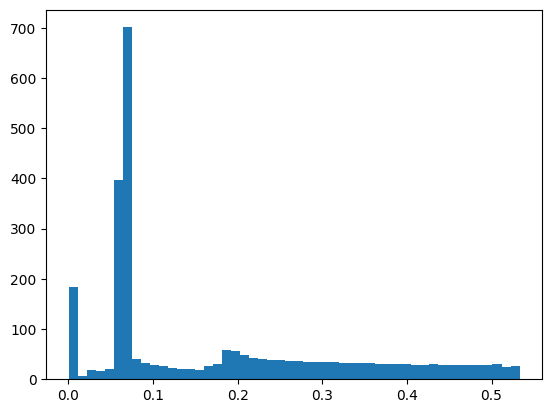

In [54]:
plt.hist(recon_error, bins=50)